In [1]:
# If there's a GPU available...
import torch
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
!pip install transformers

In [3]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt


# Download latest version
path = kagglehub.dataset_download("datasnaek/mbti-type")
print("Path to dataset files:", path)

# test
# dataset_dir = "/root/.cache/kagglehub/datasets/datasnaek/mbti-type/versions/1"
# files = os.listdir(dataset_dir)
# print("Files in dataset directory:", files)


dataset_path = "/root/.cache/kagglehub/datasets/datasnaek/mbti-type/versions/1/mbti_1.csv"
#read csv
df = pd.read_csv(dataset_path)
#print first 5 row
print(df.head())
#print info
print(df.info())

Path to dataset files: /root/.cache/kagglehub/datasets/datasnaek/mbti-type/versions/1
   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB
None


In [14]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.data.path.append('/root/nltk_data')


import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
#checking for missing value
missing_values = df.isnull().sum()
print("Missing Values:", missing_values)

#Drop with NA
df = df.dropna()  #
#
df = df.fillna(" ")  # using emppty to fill NA


Missing Values: labels    0
posts     0
dtype: int64


"We first check for missing values in our dataset and handle them by either removing the rows with missing values or replacing them with an empty string to maintain data consistency."

In [5]:
df.head() #see what's data contents

,labels,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [26]:
# ext Cleaning: Remove URLs, HTML, special characters
def clean_text(text):
    if isinstance(text, list):
        text = " ".join(text)  # Convert list back to string if needed
    text = str(text).lower()  # Convert to lowercase and ensure string format
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"<.*?>", "", text)  # Remove HTML
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Keep only letters and spaces
    return text

# Tokenization， Stopword Remove
def clean_tokens(df: pd.DataFrame) -> pd.DataFrame:
    stop_words = set(stopwords.words("english"))  # Load stopwords

    def tokenize_and_filter(text):

        words = word_tokenize(text)  # Tokenize the text
        filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
        return filtered_words  # Return cleaned word list

    df['cleaned_posts'] = df['posts'].apply(lambda x: tokenize_and_filter(clean_text(x)))  # Apply cleaning + tokenization
    return df

# Process the dataset
df = clean_tokens(df)

# Display results
print(df[['posts', 'cleaned_posts']])


                                                  posts  \
0     [intj, moments, https, sportscenter, top, ten,...   
1     [finding, lack, posts, boring, position, often...   
2     [one, https, course, say, know, blessing, abso...   
3     [intp, enjoyed, conversation, day, esoteric, g...   
4     [another, silly, misconception, approaching, l...   
...                                                 ...   
8670  [always, think, cats, fi, doms, reason, https,...   
8671  [thread, already, exists, someplace, else, htt...   
8672  [many, questions, things, would, take, purple,...   
8673  [conflicted, right, comes, wanting, children, ...   
8674  [long, since, personalitycafe, although, seem,...   

                                          cleaned_posts  
0     [intj, moments, sportscenter, top, ten, plays,...  
1     [finding, lack, posts, boring, position, often...  
2     [one, course, say, know, blessing, absolutely,...  
3     [intp, enjoyed, conversation, day, esoteric, g...  
4

In [29]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

df['cleaned_posts'] = df['cleaned_posts'].apply(lemmatize_tokens)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
df["word_count"] = df["cleaned_posts"].apply(len)
df["char_count"] = df["posts"].apply(len)
#Count length

In [30]:
from imblearn.over_sampling import RandomOverSampler


print("Class distribution before resampling:\n", df["labels"].value_counts())

# rebalance
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df.drop(columns=['labels']), df['labels'])

print("Sample cleaned post:", df['cleaned_posts'].iloc[0])  # 检查清理后的文本
df.head(20)

Class distribution before resampling:
 labels
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64
Sample cleaned post: ['intj', 'moment', 'sportscenter', 'top', 'ten', 'play', 'experience', 'life', 'http', 'repeat', 'perc', 'experience', 'immerse', 'last', 'thing', 'infj', 'friend', 'posted', 'facebook', 'committing', 'suicide', 'next', 'day', 'rest', 'http', 'sorry', 'hear', 'distress', 'natural', 'relationship', 'perfection', 'time', 'every', 'moment', 'existence', 'try', 'figure', 'hard', 'time', 'time', 'growth', 'http', 'http', 'game', 'set', 'wellbrutin', 'least', 'thirty', 'minute', 'moving', 'leg', 'mean', 'moving', 'sitting', 'desk', 'chair', 'weed', 'moderation', 'maybe', 'try', 'edible', 'healthier', 'alternative', 'come', 'three', 'item', 'determined', 'type', 'whichever', 'type', 'want', 'would

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


,labels,posts,cleaned_posts,word_count,char_count
0,INFJ,"[intj, moments, https, sportscenter, top, ten,...","[intj, moment, sportscenter, top, ten, play, e...",271,273
1,ENTP,"[finding, lack, posts, boring, position, often...","[finding, lack, post, boring, position, often,...",515,515
2,INTP,"[one, https, course, say, know, blessing, abso...","[one, course, say, know, blessing, absolutely,...",387,389
3,INTJ,"[intp, enjoyed, conversation, day, esoteric, g...","[intp, enjoyed, conversation, day, esoteric, g...",476,478
4,ENTJ,"[another, silly, misconception, approaching, l...","[another, silly, misconception, approaching, l...",437,438
5,INTJ,"[perfect, scientist, claims, scientific, infor...","[perfect, scientist, claim, scientific, inform...",681,681
6,INFJ,"[ca, draw, nails, haha, done, professionals, n...","[ca, draw, nail, haha, done, professional, nai...",616,617
7,INTJ,"[tend, build, collection, things, desktop, use...","[tend, build, collection, thing, desktop, use,...",552,553
8,INFJ,"[sure, good, question, distinction, two, depen...","[sure, good, question, distinction, two, depen...",338,340
9,INTP,"[position, actually, let, go, person, due, var...","[position, actually, let, go, person, due, var...",594,594


In [61]:
from google.colab import drive

import os
import pandas as pd

csv_path_train = "/content/drive/My Drive/APS360_team1/Project Proposal/faceexp-comparison-data-train-public.csv"

df_facial = pd.read_csv(csv_path_train, on_bad_lines="skip", engine="python")

In [62]:
df_facial.head()

,http://farm5.staticflickr.com/4108/5185055338_1dec873bf3_b.jpg,0.142578,0.266602,0.065421,0.297508,http://farm3.staticflickr.com/2127/5765052001_fa4c5fd8b0_b.jpg,0.439490,0.596178,0.289062,0.427734,...,291701,2.1,321402,2.2,321501,2.3,321902,3,322102,2.4
0,http://farm5.staticflickr.com/4108/5185055338_...,0.142578,0.266602,0.065421,0.297508,http://farm4.staticflickr.com/3543/3387356856_...,0.335938,0.441406,0.130307,0.311859,...,321402,2,321601,3,4295017797,2,4295017896,2,48316,2
1,http://farm5.staticflickr.com/4108/5185055338_...,0.142578,0.266602,0.065421,0.297508,http://farm4.staticflickr.com/3858/14540292875...,0.206442,0.524158,0.078125,0.325195,...,321902,2,322102,1,4295017797,1,4295017896,1,48316,2
2,http://farm5.staticflickr.com/4108/5185055338_...,0.718750,0.826172,0.194704,0.394081,http://farm4.staticflickr.com/3875/14501588548...,0.318665,0.488619,0.162109,0.290039,...,321501,3,321601,3,321902,3,322102,3,48316,2
3,http://farm5.staticflickr.com/4108/5185055338_...,0.718750,0.826172,0.194704,0.394081,http://farm6.staticflickr.com/5143/5693754914_...,0.244141,0.380859,0.175000,0.413235,...,321501,2,321601,3,321902,2,322102,2,41207,2
4,http://farm5.staticflickr.com/4108/5185055338_...,0.718750,0.826172,0.194704,0.394081,http://farm6.staticflickr.com/5286/5259330568_...,0.216797,0.637695,0.129927,0.862774,...,291701,2,321501,2,321601,2,321902,1,322102,3


In [70]:

#check NA
print(df_facial.isnull().sum())

# DROP NA
df_facial = df_facial.dropna().reset_index(drop=True)

# make sure each row has three pictures
df_facial = df_facial[df_facial.iloc[:, 0].str.startswith("http") & df_facial.iloc[:, 5].str.startswith("http") & df_facial.iloc[:, 10].str.startswith("http")]
df_facial.shape

http://farm5.staticflickr.com/4108/5185055338_1dec873bf3_b.jpg    0
0.142578                                                          0
0.266602                                                          0
0.065421                                                          0
0.297508                                                          0
http://farm3.staticflickr.com/2127/5765052001_fa4c5fd8b0_b.jpg    0
0.439490                                                          0
0.596178                                                          0
0.289062                                                          0
0.427734                                                          0
http://farm4.staticflickr.com/3747/8914150145_b9b336331c_b.jpg    0
0.345703                                                          0
0.453125                                                          0
0.075110                                                          0
0.262150                                        

(446535, 28)

In [72]:
import requests
import os
import cv2
import numpy as np

#Save data to the following location
save_dir = "/content/faces"
os.makedirs(save_dir, exist_ok=True)

# download image and save
def download_image(url, filename):
    try:
        response = requests.get(url, stream=True, timeout=10)
        if response.status_code == 200:
            img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
            img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
            if img is not None:
                file_path = os.path.join(save_dir, filename)
                cv2.imwrite(file_path, img)
                return file_path
    except Exception as e:
        print(f" False download: {url} | {e}")
    return None

img1_path = download_image(df.iloc[0, 0], "image1.jpg")
img2_path = download_image(df.iloc[0, 5], "image2.jpg")
img3_path = download_image(df.iloc[0, 10], "image3.jpg")

print(f"{img1_path}, {img2_path}, {img3_path}")


/content/faces/image1.jpg, /content/faces/image2.jpg, /content/faces/image3.jpg


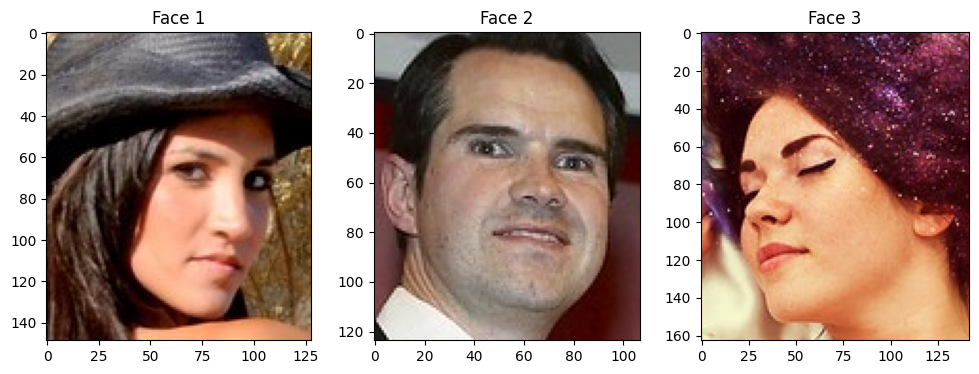

In [73]:
def crop_face(image_path, bbox):
    img = cv2.imread(image_path)
    h, w, _ = img.shape
    x1, x2, y1, y2 = int(bbox[0] * w), int(bbox[1] * w), int(bbox[2] * h), int(bbox[3] * h)
    face = img[y1:y2, x1:x2]
    return face

# finding boundry
bbox1 = df.iloc[0, 1:5].values
bbox2 = df.iloc[0, 6:10].values
bbox3 = df.iloc[0, 11:15].values

face1 = crop_face(img1_path, bbox1)
face2 = crop_face(img2_path, bbox2)
face3 = crop_face(img3_path, bbox3)

# show result
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(cv2.cvtColor(face1, cv2.COLOR_BGR2RGB))
axes[0].set_title("Face 1")
axes[1].imshow(cv2.cvtColor(face2, cv2.COLOR_BGR2RGB))
axes[1].set_title("Face 2")
axes[2].imshow(cv2.cvtColor(face3, cv2.COLOR_BGR2RGB))
axes[2].set_title("Face 3")
plt.show()
